# Modifications

Link to Interactive Notebook: 
https://colab.research.google.com/drive/1sbJTsgCsAQwCkGdLXK7EdgkaTpiTGBM1#scrollTo=T71qxHyh9p23

1. Reduced Input Dimension
2. Different handling of xco2
3. Custom rmse function

What has helped the most?
- ELU
- ADAM
- MODEL Architecture

batch size?

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-01-16 10:32:23.563636: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"

## Data Preprocessing

In [3]:
sys.path.insert(0, '../src/preprocess')

from data_preprocess import preprocess_images

X, pco2_images = preprocess_images(dir_name)
#val_X = preprocess_images_nfp(val_dir_name)

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

In [5]:
pco2_images.shape

(421, 180, 360)

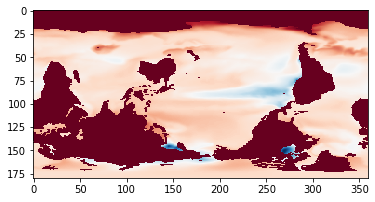

In [6]:
plt.imshow(pco2_images[1],cmap="RdBu", interpolation="nearest")

## Modeling

### Image Segmentation
CNN - Unet

Reference: 
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47


In [7]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

### Base Model

In [123]:
tf.keras.backend.clear_session()

In [11]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")


base_model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3), #pool size 3 > pool size 2
    keras.layers.Dropout(0.3),# drop out at the end of the deepest

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),


    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),    
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])


## BEST SO FAR ##

base_model.summary()

2022-01-16 09:08:34.289267: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-16 09:08:34.376509: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-16 09:08:34.603477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-01-16 09:08:34.603522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-16 09:08:36.362896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-16 09:08:36.362958: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [12]:
myLearnRate=0.001
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
base_model.compile(loss=custom_rmse, optimizer=custom_opt, metrics=["mean_squared_error"])

In [13]:
model_path="../models/base_model/base_model_new.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

#batch size 24, 32, 64 not as good
# batch size 16 the best
history = base_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=16,callbacks=callbacks)



2022-01-16 09:08:46.797561: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-16 09:08:46.956282: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


Epoch 1/100


2022-01-16 09:08:49.507530: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-01-16 09:09:58.770185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-16 09:10:01.529636: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


27/27 [==============================] - 90s 445ms/step - loss: 56.5991 - mean_squared_error: 3219.6981 - val_loss: 18.9301 - val_mean_squared_error: 1133.5333
Epoch 2/100
27/27 [==============================] - 6s 233ms/step - loss: 17.6849 - mean_squared_error: 1142.4410 - val_loss: 14.9599 - val_mean_squared_error: 1652.1178
Epoch 3/100
27/27 [==============================] - 6s 232ms/step - loss: 14.9818 - mean_squared_error: 1671.9323 - val_loss: 13.6937 - val_mean_squared_error: 1586.4778
Epoch 4/100
27/27 [==============================] - 6s 232ms/step - loss: 14.1686 - mean_squared_error: 1724.0789 - val_loss: 14.5836 - val_mean_squared_error: 1402.6648
Epoch 5/100
27/27 [==============================] - 6s 232ms/step - loss: 13.3855 - mean_squared_error: 1748.8164 - val_loss: 12.1148 - val_mean_squared_error: 1977.0574
Epoch 6/100
27/27 [==============================] - 6s 232ms/step - loss: 12.4983 - mean_squared_error: 1959.6486 - val_loss: 12.6379 - val_mean_squared_er

### Base Model Result

In [8]:

best_model = tf.keras.models.load_model('../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X,verbose=1)

2022-01-16 10:32:51.573412: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-16 10:32:51.576720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-16 10:32:51.638202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-01-16 10:32:51.638245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-16 10:32:52.196574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-16 10:32:52.196636: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

14/14 [==============================] - 25s 154ms/step


In [11]:
predicted_image[pco2_images==0]=0.0

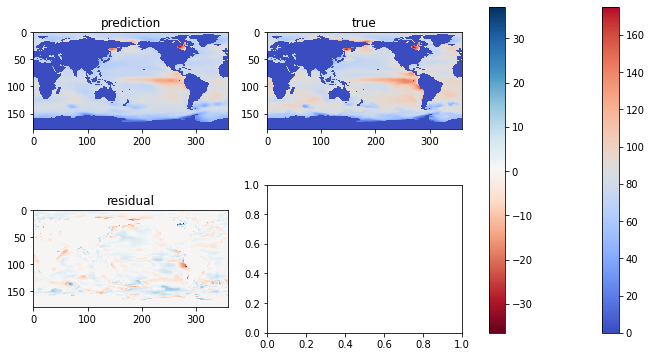

In [13]:
figure, axis = plt.subplots(2, 2,figsize=(12, 6))


img=axis[0][0].imshow(np.flipud(predicted_image[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(pco2_images[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_image[0]-pco2_images[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest")
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)



plt.savefig('../assets/cnn-unet.png')

plt.show()





In [14]:

import imageio
import matplotlib.colors as mcolors

d = predicted_image - pco2_images

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

In [16]:
filenames = []
for i in range(421):
    # plot the line chart
    figure, axis = plt.subplots(2, 2,figsize=(12, 6))

    img=axis[0][0].imshow(np.flipud(predicted_image[i]),cmap="coolwarm", interpolation="nearest")
    axis[0][0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[0][1].imshow(np.flipud(pco2_images[i]),cmap="coolwarm", interpolation="nearest")
    axis[0][1].set_title("true")

    diff=np.flipud(np.squeeze(predicted_image[i]-pco2_images[i]))
    img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
    axis[1][0].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
# build gif
with imageio.get_writer('../assets/cnn-unet.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

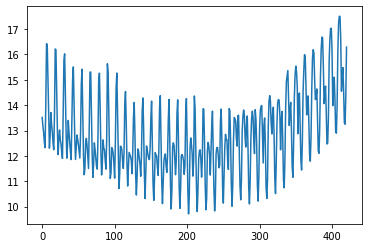

In [9]:
rmses = []

for i in range(421):    
    rmse = np.sqrt(np.mean((pco2_images[i]-predicted_image)**2))
    rmses.append(rmse)
    
plt.plot(rmses)
plt.savefig('../assets/unet-overtime.png')

## Model 1

- more complex model with a greater parameters
- need a different learning rate

In [14]:

#kernel_size matters, 2 does not work

model1 = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.35),

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.35),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])

model1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 180, 360, 32)      4032      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 360, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 120, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 120, 64)       51264     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 120, 64)       102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 40, 64)       

In [15]:
myLearnRate=0.001
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
model1.compile(loss=custom_rmse, optimizer=custom_opt, metrics=["mean_squared_error"])

In [16]:
model_path="../models/base_model/reduceddim_model1.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = model1.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=16,callbacks=callbacks)




Epoch 1/100
27/27 [==============================] - 8s 215ms/step - loss: 84.5748 - mean_squared_error: 4536.6369 - val_loss: 84.1113 - val_mean_squared_error: 4507.9634
Epoch 2/100
27/27 [==============================] - 4s 147ms/step - loss: 83.8159 - mean_squared_error: 4454.5827 - val_loss: 84.0306 - val_mean_squared_error: 4499.4692
Epoch 3/100
27/27 [==============================] - 4s 146ms/step - loss: 84.6741 - mean_squared_error: 4547.2266 - val_loss: 83.9502 - val_mean_squared_error: 4491.0205
Epoch 4/100
27/27 [==============================] - 4s 147ms/step - loss: 84.1879 - mean_squared_error: 4494.3803 - val_loss: 83.8700 - val_mean_squared_error: 4482.6050
Epoch 5/100
27/27 [==============================] - 4s 146ms/step - loss: 83.9184 - mean_squared_error: 4466.0015 - val_loss: 83.7900 - val_mean_squared_error: 4474.2129
Epoch 6/100
16/27 [================>.............] - ETA: 1s - loss: 83.9118 - mean_squared_error: 4466.6618

KeyboardInterrupt: 

In [11]:

best_model = tf.keras.models.load_model('../models/base_model/reduceddim_model1.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X,verbose=1)

14/14 [==============================] - 1s 71ms/step


### Model 1 Result

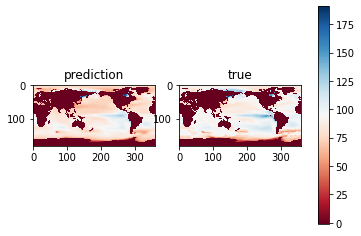

In [9]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


img=axis[0].imshow(np.flipud(np.squeeze(predicted_image[1])), cmap="RdBu", interpolation="nearest")
axis[0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[1].imshow(np.flipud(np.squeeze(pco2_images[419:421][1])), cmap="RdBu", interpolation="nearest")
axis[1].set_title("true")
plt.show()



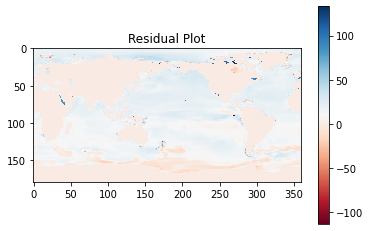

In [10]:
diff=np.flipud(np.squeeze(pco2_images[419:421][1]-predicted_image[1]))
plt.imshow(diff,cmap="RdBu", interpolation="nearest")
plt.colorbar()
plt.title("Residual Plot")

plt.show()

In [67]:
# Over time

rmses = []

for i in range(421):    
    rmse = np.sqrt(np.mean((pco2_images[i]-predicted_image)**2))
    rmses.append(rmse)

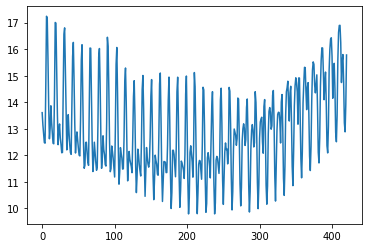

In [63]:
plt.plot(rmses)
plt.savefig('../assets/overtime.png')



## Getting PCO2 Prediction per Point

In [42]:
def inverse_scale_image(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    y_true=np.nan_to_num(df)
    y_pred[y_true==0]=0
    return y_true,y_pred


In [43]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2 = read_xarray(dir_name)

y_true,y_pred = inverse_scale_image(predicted_image,pco2.pCO2.data)  

In [45]:
print("Scaled back RMSE score:")
np.sqrt(np.mean((y_true-y_pred)**2))

Scaled back RMSE score:


8.498948497767572